# Age at first marriage

Comparing results from NSFG using my original code and lifelines.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter

from utils import decorate
from utils import values
from utils import resample_rows_weighted
from utils import round_into_bins

from empiricaldist import Pmf, Cdf

random_seed = 1

In [2]:
# Make the figures smaller to save some screen real estate.
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = [5, 3.5]

In [3]:
def set_palette(*args, **kwds):
    """Set the matplotlib color cycler.
    
    args, kwds: same as for sns.color_palette
    
    Also takes a boolean kwd, `reverse`, to indicate
    whether the order of the palette should be reversed.
    
    returns: list of colors
    """
    reverse = kwds.pop('reverse', False)
    palette = sns.color_palette(*args, **kwds)
    
    palette = list(palette)
    if reverse:
        palette.reverse()
        
    cycler = plt.cycler(color=palette)
    plt.gca().set_prop_cycle(cycler)
    return palette

In [4]:
def PercentileRow(array, p):
    """Selects the row from a sorted array that maps to percentile p.

    p: float 0--100

    returns: NumPy array (one row)
    """
    rows, cols = array.shape
    index = int(rows * p / 100)
    return array[index,]

In [5]:
def PercentileRows(ys_seq, percents):
    """Given a collection of lines, selects percentiles along vertical axis.

    For example, if ys_seq contains simulation results like ys as a
    function of time, and percents contains (5, 95), the result would
    be a 90% CI for each vertical slice of the simulation results.

    ys_seq: sequence of lines (y values)
    percents: list of percentiles (0-100) to select

    returns: list of NumPy arrays, one for each percentile
    """
    nrows = len(ys_seq)
    ncols = len(ys_seq[0])
    array = np.zeros((nrows, ncols))

    for i, ys in enumerate(ys_seq):
        array[i,] = ys

    array = np.sort(array, axis=0)

    rows = [PercentileRow(array, p) for p in percents]
    return rows

In [6]:
def MakeSurvivalCI(sf_seq, percents, flip=False):
    """Makes confidence intervals from a list of survival functions.

    sf_seq: list of SurvivalFunction
    percents: list of percentiles to select, like [5, 95]

    returns: (ts, rows) where ts is a sequence of times and
             rows contains one row of values for each percent
    """
    # find the union of all ts where the sfs are evaluated
    ts = set()
    for sf in sf_seq:
        ts |= set(sf.ts)

    ts = list(ts)
    ts.sort()

    # evaluate each sf at all times
    if flip:
        ys = 1-sf.Probs(ts)
    else:
        ys = sf.Probs(ts)
    ss_seq = [100*ys for sf in sf_seq if len(sf) > 0]

    # return the requested percentiles from each column
    rows = PercentileRows(ss_seq, percents)
    return ts, rows

In [7]:
def PlotSurvivalFunctions(sf_map):
    """Plot estimated survival functions.

    sf_map: map from group name to sequence of survival functions
    predict_flag: whether the lines are predicted or actual
    colormap: map from group name to color
    """
    for name, sf_seq in sorted(sf_map.items(), reverse=False):
        if len(sf_seq) == 0:
            continue

        sf = sf_seq[0]
        if len(sf) == 0:
            continue

        ts, rows = MakeSurvivalCI(sf_seq, [50])
        plt.plot(ts, 100-rows[0], label='19%ds'%name, alpha=0.8)

## Run the analysis with lifelines

Load the data cleaned in clean_nsfg.ipynb and run the analysis with `lifelines`

In [8]:
%time unweighted = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
unweighted.shape

CPU times: user 46.9 ms, sys: 14.2 ms, total: 61.2 ms
Wall time: 66.2 ms


(75769, 34)

In [9]:
evrmarry = unweighted['evrmarry']
values(evrmarry)

evrmarry
False    36608
True     39161
Name: count, dtype: int64

In [10]:
for name, group in unweighted.groupby('birth_index'):
    missing = group['evrmarry'] & group['agemarry'].isna()
    print(name, missing.sum())

30 0
40 9
50 18
60 33
70 40
80 21
90 2
100 1


In [11]:
def resample_by_cycle(unweighted):
    dfs = []

    for name, group in unweighted.groupby('cycle'):
        df = resample_rows_weighted(group, 'finalwgt')
        dfs.append(df)

    return pd.concat(dfs).reset_index(drop=True)

In [12]:
sample = resample_by_cycle(unweighted)

In [13]:
values(sample['birth_index'])

birth_index
30       344
40      3966
50     10201
60     15663
70     18109
80     15300
90      9537
100     2649
Name: count, dtype: int64

In [14]:
def fill_missing(df):
    for cohort in range(30, 110, 10):
        # find people in this cohort who are married but have no agemarry
        missing = (df['birth_index'] == cohort) & df['evrmarry'] & df['agemarry'].isna()
        n = missing.sum()
        if n == 0:
            continue
        
        # find people in this cohort who have been married once
        donors = (df['birth_index'] == cohort) & df['evrmarry'] & df['agemarry'].notna()

        # select their ages when married
        agemarry = df.loc[donors, 'agemarry']
        low, high = np.percentile(agemarry, [1, 99])
        index = agemarry.between(low, high)

        # fill missing data with a random sample
        sample = np.random.choice(agemarry[index], size=n, replace=True)
        df.loc[missing, 'agemarry'] = sample

In [15]:
fill_missing(sample)
missing = sample['evrmarry'] & sample['agemarry'].isna()
missing.sum()

0

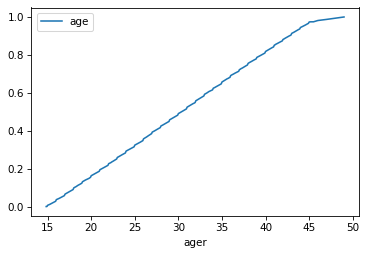

In [16]:
cdf = Cdf.from_seq(sample['ager'], name='age')
cdf.plot()
decorate()

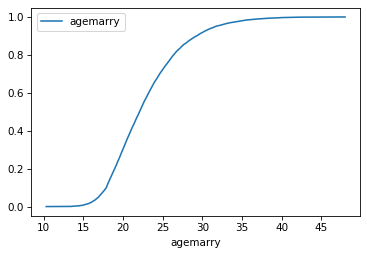

In [17]:
cdf = Cdf.from_seq(sample['agemarry'], name='agemarry')
cdf.plot()
decorate()

In [18]:
def make_kmf_map(grouped):
    """Dictionary that maps from cohort name to survival function
    """
    kmf_map = {}

    for cohort, group in grouped:
        kmf = KaplanMeierFitter()
        kmf.fit(group['duration'], group['observed'])
        series = (1 - kmf.survival_function_['KM_estimate']) * 100
        series.name = cohort
        kmf_map[cohort] = series
        
    return kmf_map

In [19]:
evrmarry = sample['evrmarry']
sample['observed'] = evrmarry
sample.loc[evrmarry, 'duration'] = sample['agemarry']
sample.loc[~evrmarry, 'duration'] = sample['ager']

In [20]:
grouped = sample.groupby('birth_index')
nsfg_map = make_kmf_map(grouped)

In [21]:
from utils import underride

def add_text(x, y, text, **options):
    ax = plt.gca()
    underride(
        options,
        transform=ax.transAxes,
        color="0.2",
        ha="left",
        va="bottom",
        fontsize=9,
    )
    plt.text(x, y, text, **options)

In [22]:
def make_title(title, subtitle, pad=30):
    plt.title(title, loc="left", pad=pad)
    add_text(0, 1.08, subtitle)
    add_text(0, 1.02, "Analysis: allendowney.com/blog")

In [23]:
def decorate_plot(**options):
    decorate(xlabel='Age',
             ylabel='Percent',
             xlim=[13, 55], 
             **options,
             )
    title = 'Percent ever married, by decade of birth'
    subtitle = 'Data: NSFG 1982-2023 '
    make_title(title, subtitle)

In [24]:
def plot_kmf_map(ax, kmf_map, cohorts, add_label=True, **options):
    """
    """
    palette = set_palette('hls', len(cohorts))
    for cohort in cohorts:
        series = kmf_map[cohort]
        label = f'{cohort+1900}s' if add_label else ''
        series.plot(ax=ax, label=label, **options)
        label = ''

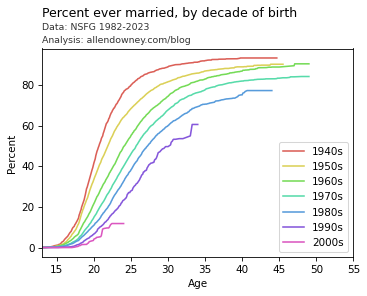

In [25]:
cohorts = range(40, 110, 10)

fig, ax = plt.subplots()
plot_kmf_map(ax, nsfg_map, cohorts)
decorate_plot()

In [26]:
kmf_series = {}

for i in range(21):
    sample = resample_by_cycle(unweighted)
    fill_missing(sample)
    evrmarry = sample['evrmarry']
    sample['observed'] = evrmarry
    sample.loc[evrmarry, 'duration'] = sample['agemarry']
    sample.loc[~evrmarry, 'duration'] = sample['ager']
    grouped = sample.groupby('birth_index')
    kmf_map = make_kmf_map(grouped)
    for cohort in kmf_map:
        kmf_series.setdefault(cohort, []).append(kmf_map[cohort])

In [27]:
def remove_spines():
    """Remove the spines of a plot but keep the ticks visible."""
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Ensure ticks stay visible
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

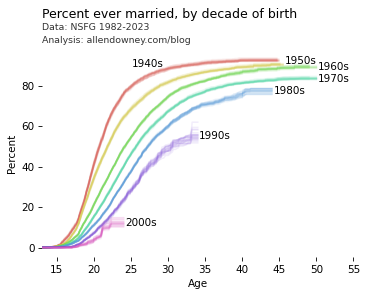

In [29]:
palette = sns.color_palette('hls', len(cohorts))
options = dict(alpha=0.1)
nudge = {40: -2, 50:2}

for i, cohort in enumerate(cohorts):
    series_list = kmf_series[cohort]
    coords = []
    for series in series_list:
        coords.append((series.index[-1], series.iloc[-1]))
        series.plot(label='', color=palette[i], **options)
        
    xs, ys = np.transpose(coords)
    x = xs.max() + 0.2
    y = ys.mean() + nudge.get(cohort, 0)
    if cohort == 40:
        x -= 20
    text = f'{1900+cohort}s'
    plt.text(x, y, text, va='center')

decorate_plot()
remove_spines()
plt.savefig('marriage23.png', dpi=300)